In [1]:
%matplotlib widget
# other options for matplotlib are: `widget`, `ipympl`, `notebook`

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
column_names = ['atom', 'x', 'y', 'z']
df = pd.read_csv('/Users/nicksmits/chee494/reference_files/sI_Reference.xyz',
                 sep='\s+',
                 names=column_names,
                 skiprows=2)
# the `sep='\s+` is necessary because I want to use whitespace
# as the separator and not just `sep=" "`

In [3]:
df

,atom,x,y,z
0,O,0.000000,0.000000,3.006056
1,O,0.000000,0.000000,9.023943
2,O,0.000000,2.320827,1.421946
3,O,0.000000,2.320827,10.608054
4,O,0.000000,9.709172,1.421946
...,...,...,...,...
133,H,7.697636,3.195408,5.240990
134,H,5.549800,8.346895,6.032925
135,H,4.332364,8.834591,6.789010
136,H,7.979980,7.547020,6.010308


In [4]:
# Get the oxygen atoms only that for the cage 
oxygen_df = df.loc[df['atom'] == "O"]

oxygen_df

,atom,x,y,z
0,O,0.000000,0.000000,3.006056
1,O,0.000000,0.000000,9.023943
2,O,0.000000,2.320827,1.421946
3,O,0.000000,2.320827,10.608054
4,O,0.000000,9.709172,1.421946
5,O,0.000000,9.709172,10.608054
6,O,6.015000,3.006056,0.000000
7,O,6.015000,9.023943,0.000000
8,O,6.015000,1.421946,2.320827
9,O,6.015000,10.608054,2.320827


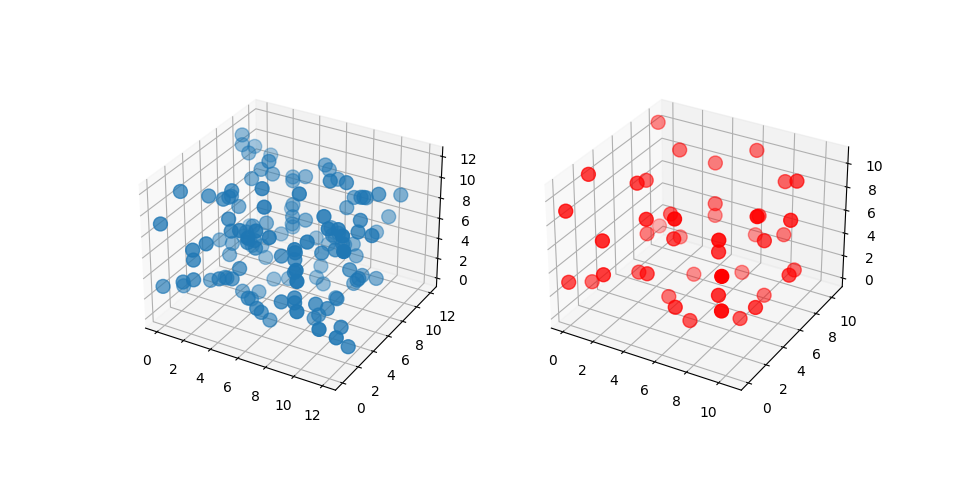

In [5]:
# Plot 3D atoms point clouds

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# Plot all atoms
ax.scatter(df['x'], df['y'], df['z'],
           marker='o',
           s=100)
ax = fig.add_subplot(1, 2, 2, projection='3d')

# Plot oxgygens only 
ax.scatter(oxygen_df['x'], oxygen_df['y'], oxygen_df['z'],
            marker='o',
            s=100, 
            c='r')
plt.show()

In [6]:
def dist(P, Q):
    return np.sqrt((P[0]-Q[0])**2 + (P[1]-Q[1])**2 + (P[2]-Q[2])**2)

In [7]:
# Known HBond atoms
oxygen_df.iloc[20]
oxygen_df.iloc[8][:]

atom           O
x          6.015
y       1.421946
z       2.320827
Name: 8, dtype: object

In [8]:
# Ball park HBond Dist value 
dist(oxygen_df.iloc[42][1:], oxygen_df.iloc[8][1:]) / dist(oxygen_df.iloc[20][1:], oxygen_df.iloc[8][1:])

1.6470261096650987

In [9]:
HBOND_DIST = 2.7
DELTA_HBOND_DIST = 0.5
LRING_TOL = 0.1

class Graph:
    def __init__(self, verticies): # input a dataframe with 0 = index, 1,2,3 = x,y,z
        # Create all verticies and find neighbours for each vertex
        self.verticies = []
        for i in range(len(verticies)):
            self.verticies.append(self.Vertex(
                i, 
                oxygen_df.iloc[i][1], ### CHANGE THIS (hardcoding is bad)
                oxygen_df.iloc[i][2],
                oxygen_df.iloc[i][3]
            ))
        
        for vertex in self.verticies:
            vertex.populate_neighbours(self.verticies)

        self.closeable = False
        self.five_ring = []
        self.five_ring_matrix = []
            
    ## Recurvise depth-first search 
    def DFSRingFinder(self, start_index, itter):
        # Get the vertex from the list of all verticies in the graph
        vertex = self.verticies[start_index]
        vertex.visited = True
        # Check if the sequence of 4 points (formed on the 3rd itteration) is closeable via a 5th point
        if itter == 3:
            # If any of the starting point's neighbours are neighbours of the current vertex's 3rd predecessor, the ring is closed
            for starting_point_neighbour in vertex.predecessor.predecessor.predecessor.neighbours:
                if vertex.is_neighbour(starting_point_neighbour):
                    print("Close ring: " + str(starting_point_neighbour.index) + ": (" + str(starting_point_neighbour.x) + ", " + str(starting_point_neighbour.y) + ", " + str(starting_point_neighbour.z) + ")")
                    self.closeable = True
                    self.five_ring.append(starting_point_neighbour)
                    return
                
        if not self.closeable: # Only run if the ring has not been closed (to avoid uneccesary computation)
            # Loop through each neighbour of the current vertex 
            for neighbour in vertex.neighbours: 
                print(itter)
                if not neighbour.visited and itter < 4 and not self.closeable:
                    print(str(neighbour.index) + ": (" + str(neighbour.x) + ", " + str(neighbour.y) + ", " + str(neighbour.z) + ")")

                    # The neighbour's predecessor is now the current vertex (used for backtracing)
                    neighbour.predecessor = vertex

                    # Check the second vertex in the sequence is 1.6 times the HBond distance from the starting point R(i, i+2) = 1.6*a
                    if itter % 2 == 0 and itter > 0:
                        if abs(1.6*vertex.dist(neighbour) - neighbour.dist(neighbour.predecessor.predecessor)) < LRING_TOL:
                            self.DFSRingFinder(neighbour.index, itter + 1) # Recursion
                            if self.closeable:
                                self.five_ring.append(neighbour) # Only add to the ring variable if it is closable
                    else:
                        self.DFSRingFinder(neighbour.index, itter + 1) # Recursion
                        if self.closeable:
                            self.five_ring.append(neighbour) # Only add to the ring if it is closeable

    def clear(self):
        # Reset graph to default
        self.closeable = False # No longer closeable
        for vertex in self.verticies: 
            vertex.predeccesor = None # Remove vertext predecessor 'memory'
            vertex.visited = False

    def add_ring_to_matrix(self, start_index):
        # If we have found a ring (len = 4 since we don't add the start index to the list in DFS)
        if len(self.five_ring) == 4:
            self.five_ring.append(self.verticies[start_index]) # Add the starting O2 to the list
            print("full")
            # print(self.five_ring)
            self.five_ring_matrix.append(self.five_ring) # Append to matrix of all rings
            print(self.five_ring_matrix)
            self.five_ring = []
        # Add for 6 memebered rings eventually
        

    class Vertex:
        def __init__(self, i, x, y, z):
            self.index = i # Particle index in the xyz file 
            self.x = x 
            self.y = y
            self.z = z
            # Visited var
            self.visited = False
            # List of first neighbours (array of Vertex objects)
            self.neighbours = set()
            self.num_neighbours = 0
            # Predecessor for backtracking
            self.predecessor = None

        def populate_neighbours(self, verticies): # Takes in a list of verticies
            count = 0
            # For every vertex, find its neighbours
            for vertex in verticies:
                if self == vertex:
                    continue
                if self.is_neighbour(vertex):
                    self.neighbours.add(vertex)
                    count += 1
            self.num_neighbours = count
        
        def is_neighbour(self, Q):
            # If the current vertex (self) and the vertex Q are the toleranced HBond distance apart, they are neighbours
            if (abs(self.dist(Q) - HBOND_DIST) < DELTA_HBOND_DIST):
                return True 
            return False 

        def dist(self, Q):
            # Simple euclidean distance calculation
            return np.sqrt((self.x-Q.x)**2 + (self.y-Q.y)**2 + (self.z-Q.z)**2)
        

In [10]:
g = Graph(oxygen_df)

In [11]:
start_index = 45
g.clear()
print(str(start_index) + " (" + str(oxygen_df.iloc[start_index][1]) + ", " + 
      str(oxygen_df.iloc[start_index][2]) + ", " + 
      str(oxygen_df.iloc[start_index][3]) + ")")
g.DFSRingFinder(start_index, 0) # <-- for recursive DFS

g.add_ring_to_matrix(start_index)

print(g.five_ring_matrix)
print(g.closeable)

45 (7.4371862425, 8.335346227, 6.0149998665)
0
35: (8.2783241245, 9.8203296708, 8.3173017447)
1
1
11: (6.0149998665, 10.6080541615, 9.7091722447)
2
2
23: (3.7516756085, 9.8203296708, 8.3173017447)
Close ring: 44: (4.5928134905, 8.335346227, 6.0149998665)
1
0
0
0
full
[[<__main__.Graph.Vertex object at 0x13749dae0>, <__main__.Graph.Vertex object at 0x1374e8940>, <__main__.Graph.Vertex object at 0x1374d8e20>, <__main__.Graph.Vertex object at 0x13749e080>, <__main__.Graph.Vertex object at 0x13749e380>]]
[[<__main__.Graph.Vertex object at 0x13749dae0>, <__main__.Graph.Vertex object at 0x1374e8940>, <__main__.Graph.Vertex object at 0x1374d8e20>, <__main__.Graph.Vertex object at 0x13749e080>, <__main__.Graph.Vertex object at 0x13749e380>]]
True


In [12]:
print("(" + str(oxygen_df.iloc[start_index][1]) + ", " + 
      str(oxygen_df.iloc[start_index][2]) + ", " + 
      str(oxygen_df.iloc[start_index][3]) + ")")
for vert in g.five_ring:
    print("(" + str(vert.x) + ", " + str(vert.y) + ", " + str(vert.z))

print(len(g.five_ring))

(7.4371862425, 8.335346227, 6.0149998665)
0


In [13]:
for i in range(len(oxygen_df)):
    print("ITTER = " + str(i))
    g.DFSRingFinder(i, 0)
    g.add_ring_to_matrix(i)
    g.clear()

ITTER = 0
ITTER = 1
0
15: (2.3203463605, 0.0, 7.4371862425)
1
14: (2.3203463605, 0.0, 4.5928134905)
2
20: (3.7516756085, 2.2096703028, 3.712698698)
2
2
0: (0.0, 0.0, 3.0060563092)
1
1
22: (3.7516756085, 2.2096703028, 8.3173017447)
2
2
10: (6.0149998665, 1.4219459324, 9.7091722447)
2
17: (2.263324258, 3.712698698, 9.8203296708)
2
42: (4.5928134905, 3.694653506, 6.0149998665)
3
20: (3.7516756085, 2.2096703028, 3.712698698)
4
4
4
4
3
36: (3.0060563092, 6.0149998665, 6.0149998665)
4
4
4
4
3
43: (7.4371862425, 3.694653506, 6.0149998665)
4
4
4
4
3
0
3: (0.0, 2.3208274883, 10.6080541615)
1
1
17: (2.263324258, 3.712698698, 9.8203296708)
2
38: (1.4219459324, 6.0149998665, 8.335827824)
3
3
3
19: (2.263324258, 8.3173017447, 9.8203296708)
4
4
4
2
2
ITTER = 2
0
16: (2.263324258, 3.712698698, 2.2096703028)
1
20: (3.7516756085, 2.2096703028, 3.712698698)
2
14: (2.3203463605, 0.0, 4.5928134905)
Close ring: 0: (0.0, 0.0, 3.0060563092)
2
2
2
1
1
1
0
full
[[<__main__.Graph.Vertex object at 0x13749dae0>, 

In [14]:
count = 0
for ring in g.five_ring_matrix:
    count += 1
    print("RING: " + str(count))
    for ring_i in ring:
        print("(" + str(ring_i.x) + ", " + str(ring_i.y) + ", " + str(ring_i.z)) 

RING: 1
(4.5928134905, 8.335346227, 6.0149998665
(3.7516756085, 9.8203296708, 8.3173017447
(6.0149998665, 10.6080541615, 9.7091722447
(8.2783241245, 9.8203296708, 8.3173017447
(7.4371862425, 8.335346227, 6.0149998665
RING: 2
(0.0, 0.0, 3.0060563092
(2.3203463605, 0.0, 4.5928134905
(3.7516756085, 2.2096703028, 3.712698698
(2.263324258, 3.712698698, 2.2096703028
(0.0, 2.3208274883, 1.4219459324
RING: 3
(2.263324258, 3.712698698, 9.8203296708
(3.7516756085, 2.2096703028, 8.3173017447
(2.3203463605, 0.0, 7.4371862425
(0.0, 0.0, 9.0239429426
(0.0, 2.3208274883, 10.6080541615
RING: 4
(6.0149998665, 3.0060563092, 0.0
(3.694653506, 4.5928134905, 0.0
(2.263324258, 3.712698698, 2.2096703028
(3.7516756085, 2.2096703028, 3.712698698
(6.0149998665, 1.4219459324, 2.3208274883
RING: 5
(6.0149998665, 9.0239429426, 0.0
(3.694653506, 7.4371862425, 0.0
(2.263324258, 8.3173017447, 2.2096703028
(3.7516756085, 9.8203296708, 3.712698698
(6.0149998665, 10.6080541615, 2.3208274883
RING: 6
(3.7516756085, 2.2096

In [15]:
# Convert each row to a tuple and then to a set to remove duplicates
unique_rows = list(set(tuple(sorted(row, key=id)) for row in g.five_ring_matrix))

# Convert back to list of lists
unique_matrix = [list(row) for row in unique_rows]

count = 0
for ring in unique_matrix:
    count += 1
    print("RING: " + str(count))
    for ring_i in ring:
        print("(" + str(ring_i.x) + ", " + str(ring_i.y) + ", " + str(ring_i.z)) 

RING: 1
(9.7666759441, 3.712698698, 2.2096703028
(10.6080541615, 6.0149998665, 3.6941723782
(7.4371862425, 3.694653506, 6.0149998665
(9.0239429426, 6.0149998665, 6.0149998665
(8.2783241245, 2.2096703028, 3.712698698
RING: 2
(9.7666759441, 3.712698698, 2.2096703028
(9.7666759441, 8.3173017447, 2.2096703028
(10.6080541615, 6.0149998665, 3.6941723782
(8.335346227, 4.5928134905, 0.0
(8.335346227, 7.4371862425, 0.0
RING: 3
(4.5928134905, 3.694653506, 6.0149998665
(2.3203463605, 0.0, 7.4371862425
(2.3203463605, 0.0, 4.5928134905
(3.7516756085, 2.2096703028, 3.712698698
(3.7516756085, 2.2096703028, 8.3173017447
RING: 4
(9.7096538537, 0.0, 7.4371862425
(9.7096538537, 0.0, 4.5928134905
(8.2783241245, 2.2096703028, 8.3173017447
(7.4371862425, 3.694653506, 6.0149998665
(8.2783241245, 2.2096703028, 3.712698698
RING: 5
(8.2783241245, 9.8203296708, 8.3173017447
(9.7666759441, 8.3173017447, 9.8203296708
(7.4371862425, 8.335346227, 6.0149998665
(10.6080541615, 6.0149998665, 8.335827824
(9.0239429426, 